In [1]:
#import relevant libraries

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
from math import *
import matplotlib.ticker
import LISA_tools as LISA

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


## Set physical and LISA constants

In [2]:
""" Cosmological values """
H0      = 69.6      # Hubble parameter today
Omega_m = 0.286     # density parameter of matter

""" LISA arm length """
L = 2.5e9 # meters

""" Transfer Frequency """
f_star = LISA.C/(2.*np.pi*L)

""" Observation Period """
Tobs = 4.*LISA.YEAR

""" Number of Michelson Data Channels """
NC = 2


G = 6.67430e-11
c = 299792458
Gpc = 3.08567758149137e25/c #Giga parsec in seconds
Msun = 1.9885e30*G/c**3 #Mass of Sun in seconds

constants = np.array([H0, Omega_m, L, f_star, Tobs, NC])

## Define functions necessary to compute the SNR for different initial orbital separation

In [73]:
def aTOfreq(a,m):
    return (m/a**3)**(1./2)/np.pi

def freqTOa(f,m):
    return (m/(np.pi*f)**2)**(1./3.)
    
def freq(f_init,m,eta,t):
    a_in = freqTOa(f_init,m)
    epsilonrr = (m/a_in)**(5./2)
    a_f=(a_in**4-256/5*eta*epsilonrr*(m)**(1./2)*a_in**(5./2.)*t)**(1./4.)
    return aTOfreq(a_f,m)

def inner_inspiral_new(m1,m2,Tobs):
    #Function to estimate initial a_0 based on 10% change over 4 years
    m=m1+m2
    eta=m1*m2/m**2
    return (256/5*eta*m**3*Tobs/(1-(90./100)**4))**(1./4)

def h_insp(f,A):
    #f is array like
    return A*f**(-7./6.)
    
def S_analytic(f,fstar,L,NC,Tobs):
    Sn = LISA.get_Sn_approx(f,f_star,L,NC)
    Sc = LISA.get_Sc_est(f,Tobs,NC)
    return Sn+Sc
    
def rho(f,A,S,delta_f):
    #f,S are array like
    h=h_insp(f,A)
    #Compute SNR using a simple Riemann sum as an approximation to the integral. 
    return (16./5.*np.sum(h**2/S)*delta_f)**(1./2.)

def mass_calculator(m1,m2):
    m=m1+m2
    mu=m1*m2/m
    eta=mu/m
    Mc=eta**(3./5.)*m
    return m,mu,eta,Mc

def freq_window_calculator(a_init,m,eta,Tobs):
    #determine initial orbital frequency
    f_init=aTOfreq(a_init,m)
    #determine final orbital frequency
    f_max=freq(f_init,m,eta,Tobs)
    #Define the frequency window to focus on, with a choice of the bin size
    delta_f = (f_max-f_init)/100.
    freq_window = np.arange(f_init,f_max,delta_f)
    return f_init,f_max,delta_f,freq_window

def SNR_detectability(m1,m2,D_l,Tobs,a_init):
    #find total mass, reduced mass, symmetric mass ratio, and chirp mass in detector frame. 
    m,mu,eta,Mc=mass_calculator(m1,m2)
    #Find overall GW amplitude constant (in units of seconds**(-1/6))
    A = np.sqrt(5./24.)*(Mc)**(5./6.)/np.pi**(2./3)/(D_l)
    f_init,f_max,delta_f,freq_window=freq_window_calculator(a_init,m,eta,Tobs)
    # Find the approximate S_n and S_c and add them to get the total noise (this is an excellent approximation for early frequencies)
    S_tot_window = S_analytic(freq_window,f_star,L,NC,Tobs)
    return rho(freq_window,A,S_tot_window,delta_f)

def find_init_a(D_l,m1,m2,Tobs):
    m_total=m1+m2
    #ISCO frequency f_ISCO -- we use this as our f_0, which is the frequency cutoff for using an inspiral model h ~ f^(-7/6)
    f_ISCO=(1.0/6.0**(3.0))**(1./.2)/m_total
    a_guess=inner_inspiral_new(m1,m2,Tobs)
    #Create array of initial a_0
    a_init_arr = np.arange(a_guess/m_total-50,a_guess/m_total+400,1)*m_total
    #empty array for SNR (rho)
    rho_arr=np.array([])
    for i in range(len(a_init_arr)):
        rho_arr=np.append(rho_arr,SNR_detectability(m1,m2,D_l,Tobs,a_init_arr[i]))
#    print(rho_arr)
    #Max initial separation at the threshold SNR
    
    threshold_index=np.where(rho_arr<10)[0][0]-1
#    print(threshold_index)
    a_0=a_init_arr[threshold_index]
    rho_0=rho_arr[threshold_index]
    return a_0/m_total

vfind_init_a=np.vectorize(find_init_a)

In [12]:
#source frame mass
m1=1e4*Msun
m2=1e4*Msun
#Distance in Giga Parsecs
D_l=0.5*Gpc
#Total mass
m_total=m1+m2
#ISCO frequency f_ISCO -- we use this as our f_0, which is the frequency cutoff for using an inspiral model h ~ f^(-7/6)
f_ISCO=(1.0/6.0**(3.0))**(1./.2)/m_total
a_guess=inner_inspiral_new(m1,m2,Tobs)
#Create array of initial a_0
a_init_arr = np.arange(a_guess/m_total-50,a_guess/m_total+200,1)*m_total
#empty array for SNR (rho)
rho_arr=np.array([])
for i in range(len(a_init_arr)):
    rho_arr=np.append(rho_arr,SNR_detectability(m1,m2,D_l,Tobs,a_init_arr[i]))


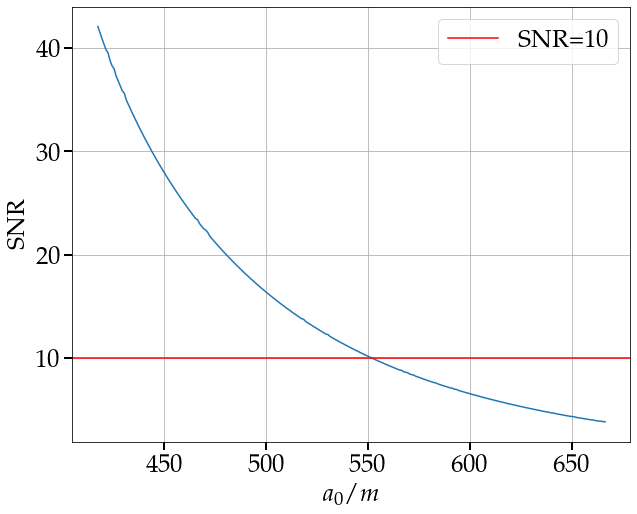

In [13]:
#Plot the SNR against the initial orbital separation

fig_SNR,ax_SNR=plt.subplots(figsize=(10,8))

""" Set the font and style of plot """
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})
# for Palatino and other serif fonts use:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})

ax_SNR.plot(a_init_arr/m_total,rho_arr)
ax_SNR.axhline(10,color='red',label=r'SNR=10')
ax_SNR.set_xlabel(r'$a_0/m $', fontsize=25)
ax_SNR.set_ylabel(r'SNR',fontsize=25)
ax_SNR.tick_params(which='both', width=2, length=8)
ax_SNR.tick_params(labelsize=25)
ax_SNR.grid('True')
ax_SNR.legend(fontsize=25)

In [14]:
#Max initial separation at the threshold SNR
threshold_index=np.where(rho_arr<10)[0][0]-1
a_0=a_init_arr[threshold_index]
rho_0=rho_arr[threshold_index]

We see that our guess for the initial orbital separation (based on 10 percent change), is not far off

## Measurability of chirp mass based on the initial orbital separation obtained above
The fractional error in measuring the chirp mass, to a good approximation, is given by
\begin{align}
\dfrac{\delta \mathcal{M}}{\mathcal{M}} & \sim \sqrt{C_{\text{ln} \mathcal{M} \ \text{ln} \mathcal{M}}} \\
& \sim \big ( \dfrac{16384}{25} \big )^{1/2} \dfrac{u_0^5}{\rho \sqrt{J(17)}} 
\end{align}

where $u_0 = (\pi \mathcal{M} f_0)^{1/3}$ is the characteristic orbital velocity, with $f_0$ being the characteristic gravitational wave frequency, and $J(q)$ is the normalized noise-weighted moment defined by $J(q)=I(q)/I(7)$, where

\begin{align}
I(q) = \int \limits_{x_{\text{min}}}^{x_{\text{max}}} \dfrac{x^{-q/3}}{S_n(x f_0)} dx
\end{align}

We will first compute the error in chirp mass for the $a_0$ we determined, evaluated at the corresponding threshold SNR of 10. Later we will obtain a constraint on $a_0$ by requring that the error in measuring chirp mass be small (less than a percent) at a given SNR (we can vary the SNR from 10 to 100 for example). 

In [144]:
chirp_mass=mass_calculator(m1,m2)[3]
u0 = (np.pi*chirp_mass*f_ISCO)**(1./3.) 

In [135]:
def I(q,x,S,xmin,xmax,dx):
    return np.sum(x**(-q/3.)/S)*dx
def J(q,x,S,xmin,xmax,dx):
    return I(q,x,S,xmin,xmax,dx)/I(7.,x,S,xmin,xmax,dx)

In [167]:
def chirp_mass_measurability(u0,rho_th,a_init,m,eta,Tobs):
        f_init,f_max,delta_f,freq_window=freq_window_calculator(a_init,m,eta,Tobs)
        #change coordinates from f --> x
        xmin=f_init/f_ISCO
        xmax=f_max/f_ISCO
        dx=delta_f/f_ISCO
        x_window=freq_window/f_ISCO
        S=1.#S_analytic(x_window*f_ISCO,f_star,L,NC,Tobs)
        J17 = J(17.,x_window,S,xmin,xmax,dx)
        return (16384./25.)**(1./2.)*(u0**5)/(rho_th*np.sqrt(J17)), f_init,f_max,delta_f,np.sqrt(J17)

In [168]:
chirp_mass_measurability(u0,10.,a_0,m_total,1./4.,Tobs/10)

(3.180947177975991e-08,
 0.0013318882307017338,
 0.001348887880428282,
 1.6999649726548134e-07,
 4.768978650025293e-12)

In [67]:
find_init_a(D_l,m1,m2,Tobs)

551.3180200958682

In [ ]:
np.savetxt('a_inner_chirp.out',np.array([a_0/m_total]))

In [71]:
vfind_init_a(D_l_arr,m1,m2,Tobs)

array([755.3180201, 551.3180201, 480.3180201])

In [72]:
np.savetxt('a_inner_chirp.out',vfind_init_a(D_l_arr,m1,m2,Tobs))